In [1]:
import numpy as np
import pandas as pd
import time
import datetime
import gc
import random
from nltk.corpus import stopwords
import re

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup

2025-01-25 13:27:23.515256: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737811643.537139 3020348 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737811643.543929 3020348 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 13:27:23.569254: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device



device(type='cuda', index=0)

In [3]:
df = pd.read_csv('train.tsv',sep='\t')
df

,Unnamed: 0,category,sourcePort,destinationPort,packetSize,word_vector,label
0,0,23,55082,80,282.0,"['0.0000040561', '0.0110203006', '0.0000202803...",1
1,1,11,49096,80,1336.0,"['0.0003691010', '0.0367275751', '0.0760753615...",2
2,2,18,32925,443,548.0,"['0.0014398994', '0.0390070778', '0.2984120546...",1
3,3,18,80,57278,1458.0,"['0.0597254051', '0.0072238334', '0.4154860168...",2
4,4,18,80,56700,1538.0,"['0.0542862358', '0.0358798597', '0.6726926119...",2
...,...,...,...,...,...,...,...
143573,143573,18,80,63160,1538.0,"['0.3877912754', '0.3877953315', '0.3877993875...",2
143574,143574,7,57272,53,300.0,"['0.0574661826', '0.0574702387', '0.0232168570...",2
143575,143575,18,36568,443,701.0,"['0.0003691010', '0.0000202803', '0.0000973453...",1
143576,143576,16,1556,47421,29694.0,"['0.2313451905', '0.0127522359', '0.2204911882...",2


In [4]:
# Load your dataset (assuming you have a list of packets and labels)
for i in range(len(df)):
    df.iloc[i,6]=  df.iloc[i,6]-1
print(df.head())
packets = df['word_vector']
labels = df['label'].tolist()
dfFeature = list()
for index in range(len(packets)):
  Str = re.sub("[^A-Za-z0-9.]+", " ",packets[index]).strip()
  dfFeature.append(Str)

   Unnamed: 0  category  sourcePort  destinationPort  packetSize  \
0           0        23       55082               80       282.0   
1           1        11       49096               80      1336.0   
2           2        18       32925              443       548.0   
3           3        18          80            57278      1458.0   
4           4        18          80            56700      1538.0   

                                         word_vector  label  
0  ['0.0000040561', '0.0110203006', '0.0000202803...      0  
1  ['0.0003691010', '0.0367275751', '0.0760753615...      1  
2  ['0.0014398994', '0.0390070778', '0.2984120546...      0  
3  ['0.0597254051', '0.0072238334', '0.4154860168...      1  
4  ['0.0542862358', '0.0358798597', '0.6726926119...      1  


In [5]:
print(len(dfFeature))

143578


In [6]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [7]:
print(' Original: ', dfFeature[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(dfFeature[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(dfFeature[0])))

 Original:  0.0000040561 0.0110203006 0.0000202803 0.0000973453 0.8533533432 0.0000243363 0.0739094283 0.0000730090 0.0000770650 0.8668600053 0.0001338498 0.8668640613 0.8668681174 0.8668721734 0.0012857693 0.0012938814 0.0012898254
Tokenized:  ['0', '.', '000', '##00', '##40', '##56', '##1', '0', '.', '01', '##10', '##20', '##30', '##0', '##6', '0', '.', '000', '##0', '##20', '##28', '##0', '##3', '0', '.', '000', '##0', '##9', '##7', '##34', '##53', '0', '.', '85', '##33', '##53', '##34', '##32', '0', '.', '000', '##0', '##24', '##33', '##6', '##3', '0', '.', '07', '##39', '##0', '##9', '##42', '##8', '##3', '0', '.', '000', '##0', '##7', '##30', '##0', '##90', '0', '.', '000', '##0', '##7', '##70', '##65', '##0', '0', '.', '86', '##6', '##86', '##00', '##0', '##53', '0', '.', '000', '##13', '##38', '##49', '##8', '0', '.', '86', '##6', '##86', '##40', '##6', '##13', '0', '.', '86', '##6', '##86', '##8', '##11', '##7', '##4', '0', '.', '86', '##6', '##8', '##7', '##21', '##7', '##34'

In [7]:
input_ids = []
attention_masks = []

# For every tweet...
for tweet in dfFeature:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start- for classification tasks
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens 
    #   (7) The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them.
    ##      For the BertTokenizer, 1 indicates a value that should be attended to, while 0 indicates a padded value.
    encoded_dict = tokenizer.encode_plus(
                        tweet,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('\nOriginal: ', dfFeature[0])
print('\nToken IDs:', input_ids[0])
print('\nAttension Mask:', attention_masks[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/sankarkumar/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



Original:  0.0000040561 0.0110203006 0.0000202803 0.0000973453 0.8533533432 0.0000243363 0.0739094283 0.0000730090 0.0000770650 0.8668600053 0.0001338498 0.8668640613 0.8668681174 0.8668721734 0.0012857693 0.0012938814 0.0012898254

Token IDs: tensor([  101,  1014,  1012,  2199,  8889, 12740, 26976,  2487,  1014,  1012,
         5890, 10790, 11387, 14142,  2692,  2575,  1014,  1012,  2199,  2692,
        11387, 22407,  2692,  2509,  1014,  1012,  2199,  2692,  2683,  2581,
        22022, 22275,  1014,  1012,  5594, 22394, 22275, 22022, 16703,  1014,
         1012,  2199,  2692, 18827, 22394,  2575,  2509,  1014,  1012,  5718,
        23499,  2692,  2683, 20958,  2620,  2509,  1014,  1012,  2199,  2692,
         2581, 14142,  2692, 21057,  1014,  1012,  2199,  2692,  2581, 19841,
        26187,  2692,  1014,  1012,  6564,  2575, 20842,  8889,  2692, 22275,
         1014,  1012,  2199, 17134, 22025, 26224,  2620,  1014,  1012,  6564,
         2575, 20842, 12740,  2575, 17134,  1014,  10

In [8]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
#val_size = int(0.2 * len(dataset))
val_size = len(dataset)  - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

114,862 training samples
28,716 validation samples


In [9]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [10]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

if device.type == 'cuda':
# Tell pytorch to run this model on the GPU.
    model = model.cuda()
    print("\n\nGPU Enabled.")
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




GPU Enabled.


In [11]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/home/sankarkumar/.local/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 10

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create a schedule with a learning rate that decreases linearly from the initial lr 
# set in the optimizer to 0, after a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [24]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    #print(pred_flat)
    return np.sum(pred_flat == labels_flat) / len(labels_flat), pred_flat


In [13]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [16]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)        
        loss = output.loss
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    best_eval_accuracy = np.Inf
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            output= model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()
        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.4f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy < best_eval_accuracy:
        torch.save(model, 'bert_model')
        best_eval_accuracy = avg_val_accuracy
    #print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    #print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("\n\n")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
print(f"\n\nTraining completed and following are the stats {training_stats}!")


======== Epoch 1 / 10 ========
Training...

  Average training loss: 0.1396
  Training epcoh took: 2:29:36

Running Validation...
  Accuracy: 0.9748

======== Epoch 2 / 10 ========
Training...

  Average training loss: 0.0804
  Training epcoh took: 2:46:57

Running Validation...
  Accuracy: 0.9820

======== Epoch 3 / 10 ========
Training...

  Average training loss: 0.0632
  Training epcoh took: 2:29:02

Running Validation...
  Accuracy: 0.9828

======== Epoch 4 / 10 ========
Training...

  Average training loss: 0.0532
  Training epcoh took: 2:28:45

Running Validation...
  Accuracy: 0.9846

======== Epoch 5 / 10 ========
Training...

  Average training loss: 0.0447
  Training epcoh took: 2:28:37

Running Validation...
  Accuracy: 0.9857

======== Epoch 6 / 10 ========
Training...

  Average training loss: 0.0383
  Training epcoh took: 2:30:06

Running Validation...
  Accuracy: 0.9873

======== Epoch 7 / 10 ========
Training...

  Average training loss: 0.0333
  Training epcoh took: 

In [17]:
#pip install --upgrade torch torchvision torchaudio
#export TORCH_USE_CUDA_DSA=1

In [18]:
#***************Save the model*******************

# Define paths to save the model and optimizer state
model_save_path = "bert_model.pth"
optimizer_save_path = "optimizer.pth"
scheduler_save_path = "scheduler.pth"

# Save the model's state_dict (parameters)
torch.save(model.state_dict(), model_save_path)

# Save the optimizer's state_dict
torch.save(optimizer.state_dict(), optimizer_save_path)

# Save the scheduler's state_dict
torch.save(scheduler.state_dict(), scheduler_save_path)

print(f"Model and optimizer state have been saved to {model_save_path} and {optimizer_save_path}")

Model and optimizer state have been saved to bert_model.pth and optimizer.pth


In [16]:
# *************Loading the Model for Future Training **************************

# Define paths to save the model and optimizer state
model_save_path = "bert_model.pth"
optimizer_save_path = "optimizer.pth"
scheduler_save_path = "scheduler.pth"

# Initialize the model (same architecture as the saved model)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",  # Base model
    num_labels=2          # Adjust to match your use case
)

# Load the saved state dictionary into the model
model.load_state_dict(torch.load(model_save_path))

# Move the model to the appropriate device
model.to(device)

# Recreate and load the optimizer state
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)
optimizer.load_state_dict(torch.load(optimizer_save_path))

# Recreate and load the scheduler state (if applicable)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
scheduler.load_state_dict(torch.load(scheduler_save_path))

print("Model, optimizer, and scheduler states have been loaded.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3020348/467201651.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We

Model, optimizer, and scheduler states have been loaded.


/tmp/ipykernel_3020348/467201651.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  scheduler.load_state_dict(torch.load(scheduler_save_path))


In [29]:
# ********* testing************

# Put the model in evaluation mode
print("\nRunning Testing...")
t0 = time.time()
model.eval()

# Tracking variables
test_accuracy = 0
test_loss = 0
nb_test_steps = 0
test_dataloader = validation_dataloader
p = list()
actual_l = list()

# Iterate through the test dataset
for batch in test_dataloader:
    # Unpack the batch
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Disable gradient computation
    with torch.no_grad():
        # Forward pass
        output = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels
        )
    
    # Get loss and logits
    loss = output.loss
    logits = output.logits
    test_loss += loss.item()

    # Move logits and labels to the CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate accuracy for this batch
    ft_a, pe = flat_accuracy(logits, label_ids)
    test_accuracy += ft_a
    p.extend(pe)
    actual_l.extend(label_ids)

# Calculate the average loss and accuracy
avg_test_loss = test_loss / len(test_dataloader)
avg_test_accuracy = test_accuracy / len(test_dataloader)

# Measure how long the testing process took
testing_time = format_time(time.time() - t0)

# Print testing results
print("")
print("  Testing Loss: {0:.4f}".format(avg_test_loss))
print("  Testing Accuracy: {0:.4f}".format(avg_test_accuracy))
print("  Testing took: {:}".format(testing_time))


Running Testing...

  Testing Loss: 0.0276
  Testing Accuracy: 0.9945
  Testing took: 0:11:59


Accuracy:  0.9944630171333054
Precision:  0.992821299135768
Recall:  0.996084189916789
F1 score:  0.994450068065203


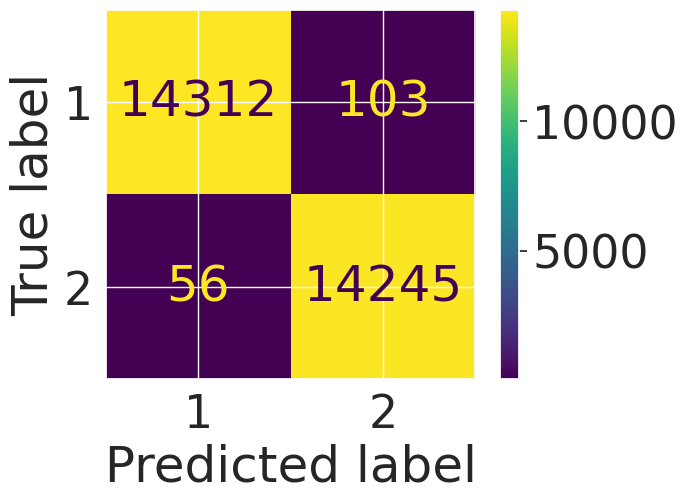

In [42]:
from sklearn import metrics
import matplotlib.pyplot as plt
y_test = p
y_pred = actual_l
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
print('Precision: ',metrics.precision_score(y_test, y_pred))
print('Recall: ',metrics.recall_score(y_test, y_pred))
print('F1 score: ',metrics.f1_score(y_test, y_pred))


confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1,2])
cm_display.plot()
plt.savefig("ConfusionM.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

In [30]:
actual_l

[0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
